In [1]:
!pip3 install tmdbv3api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# importo las librerías necesarias
import os
import time
from pathlib import Path

import pandas as pd
import numpy as np

from tmdbv3api import TMDb
import json
import requests

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Cargo los datasets de MovieLens
dir = '/content/drive/MyDrive/LaboDatos_1C2022/tp_final/data/MovieLens/'
files = [os.path.join(dir, file) for file in os.listdir(dir)]

movie_dict = {Path(file).name.split('.')[0] : pd.read_csv(file) for file in files}

In [5]:
df_ratings = movie_dict['ratings']
df_movies = movie_dict['movies']
df_links = movie_dict['links']

Veo que pinta tiene cada DataFrame: tamaño, cantidad de datos nulos.

In [6]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [7]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Pasemos timestamp a un formato legible de fecha

In [8]:
df_ratings['timestamp'] = df_ratings['timestamp'].apply(lambda x: time.localtime(x))
df_ratings['timestamp'] = df_ratings['timestamp'].apply(lambda x: time.strftime("%Y-%m-%d", x))

In [9]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,2006-05-17
1,1,306,3.5,2006-05-17
2,1,307,5.0,2006-05-17
3,1,665,5.0,2006-05-17
4,1,899,3.5,2006-05-17


Veamos en qué intervalo de fechas están contenidas las reseñas

In [10]:
print(df_ratings['timestamp'].min())
print(df_ratings['timestamp'].max()) 

1995-01-09
2019-11-21


Cantidad de películas y de usuarios que realizaron reseñas

In [11]:
# Cantidad de ususarios distintos
df_ratings.userId.unique().size

162541

In [12]:
# Cantidad de pelis distintas
df_ratings['movieId'].nunique()

59047

In [13]:
df_user_stats = df_ratings.groupby(['userId']).describe()

Visualicemos los datos: tomemos los primeros 10 usuarios y veamos como se distribuyen sus puntuaciones. Podemos hacer lo mismo fijando películas.

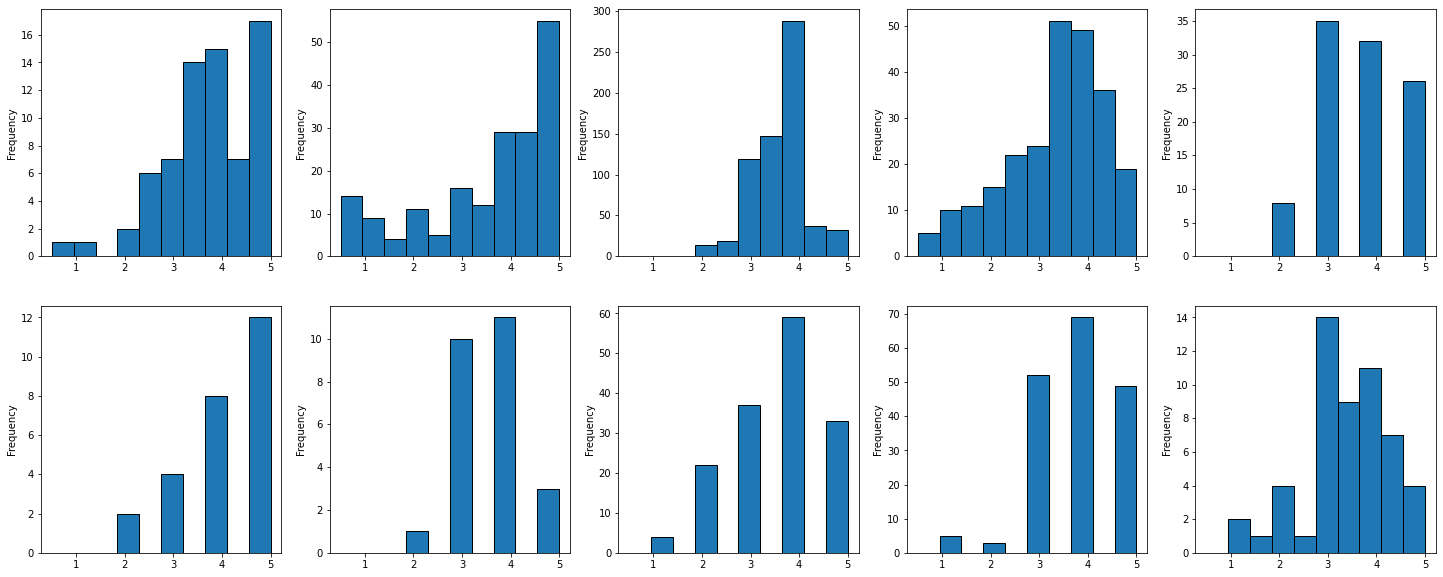

In [14]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(25, 10))

for idx, ax in enumerate(axes.flat):
  usr = idx + 1
  (df_ratings[df_ratings['userId']==usr]['rating']
   .plot(kind='hist', ax=ax, align='mid', ec='black',
         range=(0.5, 5), bins=10, rwidth=1))


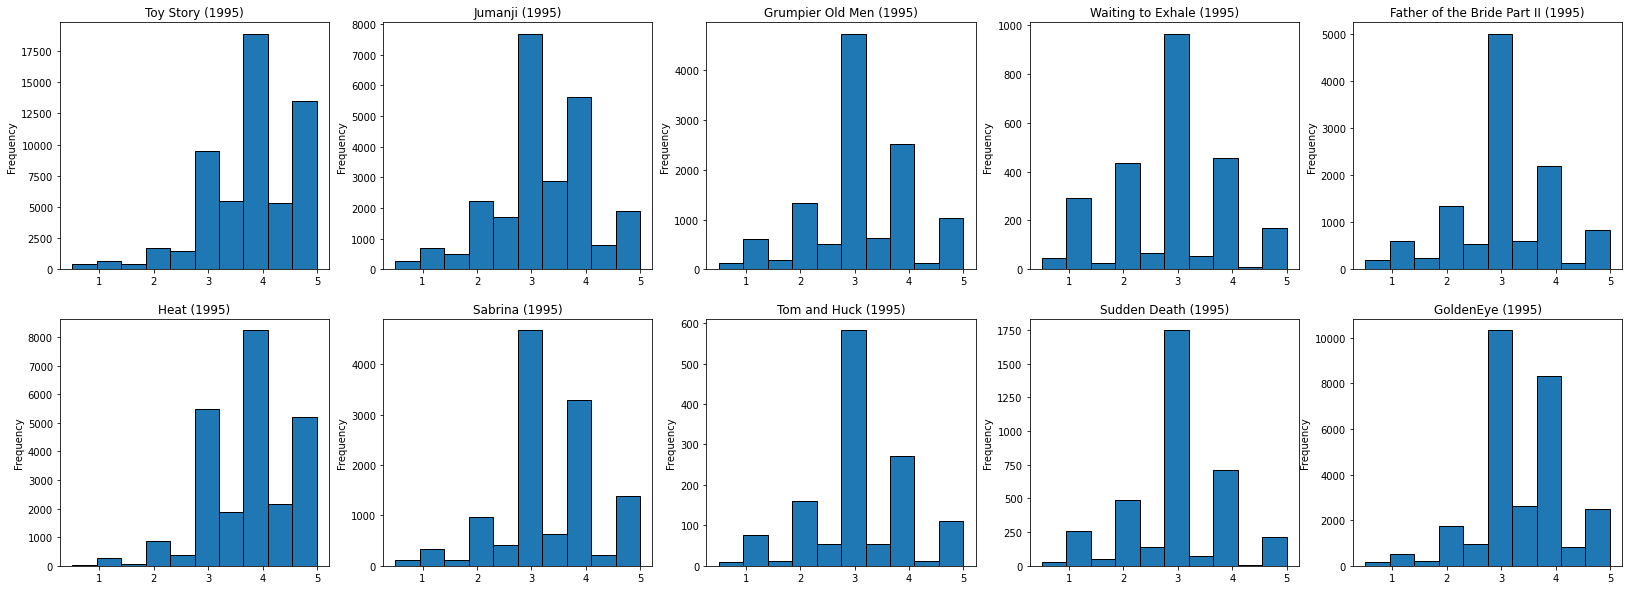

In [15]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(28, 10))

for idx, ax in enumerate(axes.flat):
  movie = idx + 1
  (df_ratings[df_ratings['movieId']==movie]['rating']
   .plot(kind='hist', ax=ax, align='mid', ec='black',
         range=(0.5, 5), bins=10, rwidth=1))
  ax.set_title(df_movies.loc[idx, 'title'])

In [16]:
# Guardamos los ratings
data_path = '/content/drive/MyDrive/LaboDatos_1C2022/tp_final/data'
file_name = 'ratings.csv'
df_ratings.to_csv(os.path.join(data_path, file_name), index=False)

Veamos los otros Data Sets: df_movies y df_links

In [17]:
df_movies.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [18]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [19]:
df_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


In [20]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [21]:
# Veamos si los movieIds son los mismos en ambos datasets
len(set(df_ratings['movieId'].unique()).intersection(set(df_movies['movieId'].unique())))

# Todos los ids en df_ratings están en df_movies, y df_movies no tiene nulos en los títulos por lo que cada id va a tener un título

59047

In [22]:
# Me voy a quedar solo con las películas que tienen alguna review
df_movies = df_movies[df_movies['movieId'].isin(df_ratings['movieId'].unique())] 

In [23]:
df_movies['movieId'].nunique()

59047

df_links tiene los id para poder juntar df_movies con los datos de IMDB. Agregamos esa data a df_movies haciendo un merge. 

Antes cambiamos el formato del feature genres

In [24]:
# Pasamos a listas de generos
df_movies['genres'] = df_movies['genres'].apply(lambda x: x.split('|'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
# Mergeamos los valores sobre los Id de las películas
df = df_movies.merge(df_links, on='movieId')

In [26]:
df.head()

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",114709,862.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",113497,8844.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",113228,15602.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",114885,31357.0
4,5,Father of the Bride Part II (1995),[Comedy],113041,11862.0


Con esto terminamos con los datos de MovieLens. Pasemos a incorporar los datos de Imdb, con el archivo que armamos en el notebook https://colab.research.google.com/drive/1G2LjoUOHJsEPHQ5kOnZ_i9yP6IreKDye#scrollTo=a273df58 a partir de los datos disponibles en https://datasets.imdbws.com/

In [27]:
file_imdb = '/content/drive/MyDrive/LaboDatos_1C2022/tp_final/data/data_completa_imdb.csv'
df_imdb = pd.read_csv(file_imdb)

In [28]:
ids_movielens = df['imdbId'].unique()

In [29]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611473 entries, 0 to 611472
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          611473 non-null  object 
 1   primaryTitle    611473 non-null  object 
 2   originalTitle   611473 non-null  object 
 3   isAdult         611473 non-null  float64
 4   startYear       531583 non-null  float64
 5   runtimeMinutes  385158 non-null  float64
 6   genres          539943 non-null  object 
 7   averageRating   278912 non-null  float64
 8   numVotes        278912 non-null  float64
 9   directors       611473 non-null  object 
 10  writers         611473 non-null  object 
dtypes: float64(5), object(6)
memory usage: 51.3+ MB


Veamos si los ids de imdb coinciden con los que figuran en MovieLens. Para eso le damos formato a los de imdb.

In [30]:
ids_imdb = df_imdb['tconst'].apply(lambda x: x[2:]).astype(int).tolist()

In [31]:
len(set(ids_imdb).intersection(set(ids_movielens))) # Hay 9000 películas que no tienen info en imdb

50047

Vemos que hay 9000 películas sin info de imdb. Veamos cuáles son.

In [33]:
# Quiero ver las pelis que no están en imdb
df[df['imdbId'].isin(set(ids_movielens)-set(ids_imdb))]

,movieId,title,genres,imdbId,tmdbId
27,28,Persuasion (1995),"[Drama, Romance]",114117,17015.0
50,51,Guardian Angel (1994),"[Action, Drama, Thriller]",109950,117164.0
97,99,Heidi Fleiss: Hollywood Madam (1995),[Documentary],113283,63076.0
119,121,"Boys of St. Vincent, The (1992)",[Drama],106473,32119.0
218,220,Castle Freak (1995),[Horror],112643,18256.0
...,...,...,...,...,...
59023,209089,An Impossible Balancing Feat (1902),[(no genres listed)],227866,108289.0
59024,209101,Hua yang de nian hua (2001),[(no genres listed)],286704,187548.0
59028,209123,Square Roots: The Story of SpongeBob SquarePan...,[Documentary],1489931,341531.0
59029,209129,Destination Titan (2011),[Documentary],2361219,421074.0


Tiramos estas pelis por ahora

In [34]:
df = df[df['imdbId'].isin(set(ids_imdb))]
print(df.shape)

(50047, 5)


In [35]:
# Hago la modificación al formato del id para poder hacer el match con el otro df
df_imdb['tconst'] = df_imdb['tconst'].apply(lambda x: x[2:]).astype(int)

Hacemos el merge final entre datos de Imdb y MovieLens. Estos son los datos con los que vamos a trabajar en el recomendador de películas.

In [36]:
df_merge = df.merge(df_imdb.rename(columns={'tconst': 'imdbId'}), on='imdbId', how='left')

In [37]:
df_merge.head()

,movieId,title,genres_x,imdbId,tmdbId,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres_y,averageRating,numVotes,directors,writers
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",114709,862.0,Toy Story,Toy Story,0.0,1995.0,81.0,"['Adventure', 'Animation', 'Comedy']",8.3,965708.0,['John Lasseter'],['John Lasseter' 'Pete Docter' 'Andrew Stanton...
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",113497,8844.0,Jumanji,Jumanji,0.0,1995.0,104.0,"['Adventure', 'Comedy', 'Family']",7.0,337453.0,['Joe Johnston'],['Jonathan Hensleigh' 'Greg Taylor' 'Jim Strai...
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",113228,15602.0,Grumpier Old Men,Grumpier Old Men,0.0,1995.0,101.0,"['Comedy', 'Romance']",6.6,27243.0,['Howard Deutch'],['Mark Steven Johnson']
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",114885,31357.0,Waiting to Exhale,Waiting to Exhale,0.0,1995.0,124.0,"['Comedy', 'Drama', 'Romance']",5.9,10877.0,['Forest Whitaker'],['Terry McMillan' 'Ronald Bass']
4,5,Father of the Bride Part II (1995),[Comedy],113041,11862.0,Father of the Bride Part II,Father of the Bride Part II,0.0,1995.0,106.0,"['Comedy', 'Family', 'Romance']",6.0,37702.0,['Charles Shyer'],['Albert Hackett' 'Frances Goodrich' 'Nancy Me...


In [38]:
data_path = '/content/drive/MyDrive/LaboDatos_1C2022/tp_final/data'
file_name = 'data_movielens+imdb.csv'
df_merge.to_csv(os.path.join(data_path, file_name), index=False)